In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import torch
from torch import nn

import os
import sys
import glob
import pickle

In [2]:
SEED = 52
torch.manual_seed(SEED)

In [3]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:
/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [4]:
SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synthetic_exp_2d_20181206-160527.pkl
../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl


In [5]:
# SET THESE PARAMETERS
process_dim = 2
print("Process dimension: {}".format(process_dim))
chosen_data_file = SYNTH_DATA_FILES[2]
print("Data file: {}".format(chosen_data_file))

Process dimension: 2
Data file: ../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl


In [6]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)
print(seq_times.shape)

Loading 2-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	[0.1 0.1]
alpha	[[0.1  0.01]
 [0.01 0.1 ]]
decay	1
tmax	3600
torch.Size([4000, 921])


# Neural network

In [134]:
from utils import one_hot_embedding

In [135]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= f(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [136]:
from train_functions import train_decayrnn, plot_loss

In [137]:
# define training data
train_size = 3000
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 3000
Train event times shape torch.Size([3000, 921])
Train event types shape torch.Size([3000, 921])
Train seq lengths shape torch.Size([3000])


In [139]:
process_dim = 2
hidden_size = 64
model = HawkesDecayRNN(process_dim, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.020)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 6

loss_hist, train_hist = train_decayrnn(
    model, optimizer, train_times_tensor,
    train_seq_types, train_seq_lengths, tmax,
    BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 6
Train size: 3000


KeyboardInterrupt: 

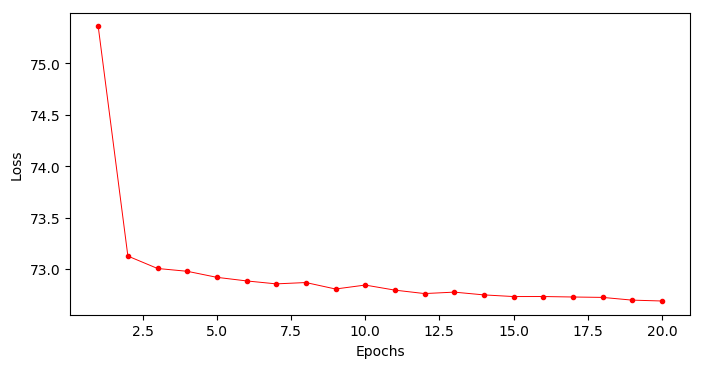

In [188]:
_ = plot_loss(EPOCHS, loss_hist)

In [189]:
import datetime
# Generate save params to record the model
# Model file dump
SAVED_MODELS_PATH = '../saved_models'
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
# print("Saved models directory: {}".format(SAVED_MODELS_PATH))

In [190]:
# This cell resets the timestamp !!
date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)

Now we save the model down to a file, and record the data files on which it was trained.

In [193]:
import json

filename_base = "{}-{}_hidden{}-{}".format(
    model.__class__.__name__, extra_tag,
    hidden_size, now_timestamp)
filename_model_save = filename_base + ".pth"
model_filepath = os.path.join(SAVED_MODELS_PATH, filename_model_save)
print("Model save file path: {}".format(model_filepath))

Model save file path: ../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth


In [194]:
file_correspondance = {
    "model_path": model_filepath,
    "data_path": chosen_data_file
}
print(file_correspondance)

{'model_path': '../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth', 'data_path': '../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl'}


In [195]:
with open(os.path.join(SAVED_MODELS_PATH, "train_data_correspondance.jsonl"), "a") as f:
    json.dump(file_correspondance, f)

print("Saving model state dict to {}".format(model_filepath))
torch.save(model.state_dict(), model_filepath)

Saving model state dict to ../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth


# Model evaluation

In [176]:
tmax = 3600

Let us load up a model

In [320]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen

In [321]:
MODEL_FILES = glob.glob("../saved_models/*.pth")
for p in MODEL_FILES:
    print(p)

../saved_models/HawkesLSTM-2d_hidden64-20181209-011016.pth
../saved_models/HawkesLSTM-1d_hidden64-20181206-235311.pth
../saved_models/HawkesDecayRNN-2d_hidden64-20181209-010709.pth
../saved_models/HawkesDecayRNN-1d_hidden64-20181206-234848.pth


In [322]:
load_filename = MODEL_FILES[2]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print(load_file_timestamp)

chosen file: ../saved_models/HawkesDecayRNN-2d_hidden64-20181209-010709.pth
20181209-010709


In [324]:
process_dim = 2
hidden_size = 64
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))

Hidden size: 64


## Sequence generation

### Untrained model, random weights

In [252]:
print("Real end time: {}".format(tmax))

Real end time: 3600


In [253]:
raw_model = HawkesDecayRNN(2, hidden_size)
generator_base = HawkesRNNGen(raw_model)

Process model dim:	2	Hidden units:	64


no. of events: 12
0: type 0
1: type 1


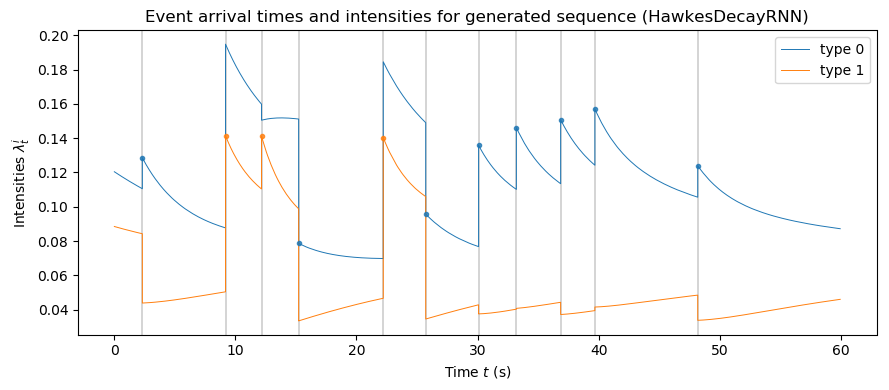

In [258]:
tmax_simu = 60
generator_base.generate_sequence(tmax_simu, record_intensity=True)

fig = generator_base.plot_events_and_intensity(debug=False)
fig.tight_layout()

### On trained model

In [325]:
RESULT_BASEDIR = "../results"

MODEL_NAME = model.__class__.__name__
print(MODEL_NAME)

HawkesDecayRNN


In [326]:
generator = HawkesRNNGen(model, record_intensity=False)

Process model dim:	2	Hidden units:	64


no. of events: 42
0: type 0
1: type 1


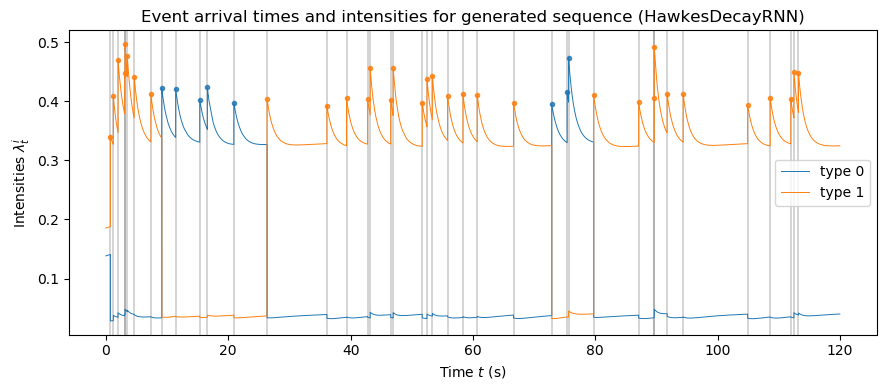

In [330]:
tmax_simu = 120
generator.generate_sequence(tmax_simu, record_intensity=True)
fig_intensity_stream = generator.plot_events_and_intensity()

In [192]:
fig_intensity_stream.savefig("../results/intensity_{}_{}d_hidden{}_{}.pdf".format(
    MODEL_NAME, process_dim, hidden_size, load_file_timestamp))

## Sequence length distribution

In [193]:
from utils import evaluation

In [199]:
generator.generate_sequence(tmax)

In [200]:
print(len(generator.event_times))
print(len(generator._plot_times))

1426
4126


In [362]:
gen_seq_lengths, gen_seq_types_lengths = evaluation.generate_multiple_sequences(generator, tmax)

KeyboardInterrupt: 

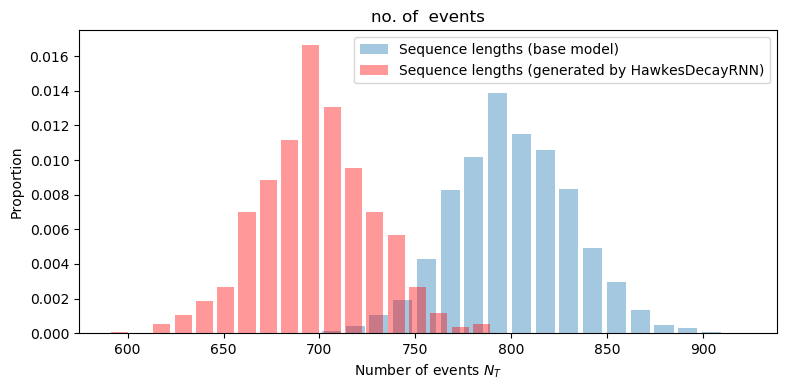

In [109]:
if process_dim > 1:
    num_plots = process_dim + 1
else:
    num_plots = 1
fig, axes = plt.subplots(num_plots, 1, figsize=(8,4+(num_plots-1)*3), dpi=100)
ax0 = axes[0] if num_plots > 1 else axes
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}
gen_label = "Sequence lengths (generated by {:})".format(MODEL_NAME)
_ = ax0.hist(seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label=gen_label,
            color='red', **hist_opts)
ax0.legend()
if num_plots > 1:
    ax0.set_title('no. of events (all types, including starter type)')
else:
    ax0.set_title('no. of  events')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
if num_plots > 1:
    axt = axes[1:]
    for i, ax in enumerate(axt):
        # get the sequence lengths for the event types
        typ_seq_lengths = (seq_types == i).sum(dim=1)
        gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
        ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
                label="Sequence lengths (base model)",
                **hist_opts)
        ax.hist(gen_typ_seq_lengths,
                bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
                label=gen_label,
                color='red', **hist_opts)
        ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
        ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [110]:
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "length_distrib"
distrib_plot_filepath = "{:}/{:}_{:}-{}-hidden_{}-{}.pdf".format(
    RESULT_BASEDIR, model_perf_indicator, MODEL_NAME,
    extra_tag, model.hidden_size, load_file_timestamp)
fig.savefig(distrib_plot_filepath)

## Event prediction

The $L_2$-wise best estimator for the next event occurrence time is given by

$$
\begin{aligned}
    \hat{t}_i &= \mathbb{E}[t_i\mid\mathcal F_{t_{i-1}}] \\
    &= t_{i-1} + \int_0^\infty u p_i(u)\, du
\end{aligned}
$$

In [316]:
import tqdm
from models.decayrnn import read_predict

In [317]:
dataset_size = seq_times.shape[0]
print(dataset_size)

train_size = 3000
test_size = 1000

4000


2554
last event: time 3593.693 type 1.000
next event: time 3593.927 type 1.000, in 0.234
type probabilities: tensor([0.0004, 0.9894])
(tensor(4.8801), tensor(0.2341), tensor(21.5847), tensor(1), tensor(1))


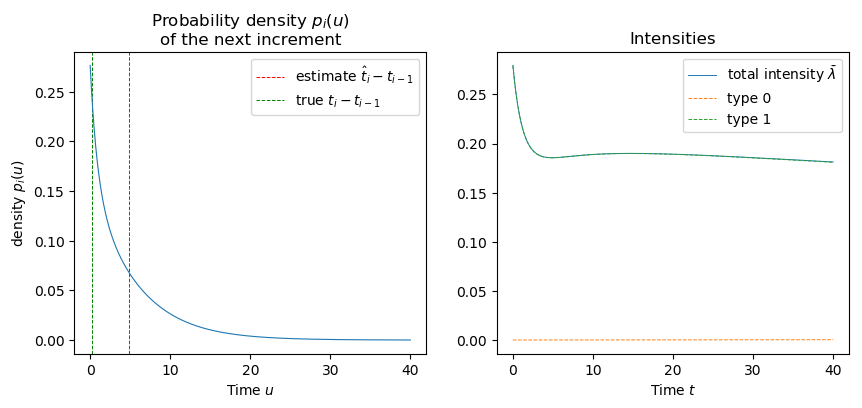

In [319]:
my_index = torch.randint(0, dataset_size, (1,)).int().item()
print(my_index)

_seq_data = (seq_times[my_index],
             seq_types[my_index],
             seq_lengths[my_index])

restup, fig = read_predict(model, *_seq_data, plot=True, print_info=True)
print(restup)

In [385]:
fig.savefig('decayrnn_2d_prediction_graphs__.pdf')

In [292]:
estimates = []
real_incrs = []
errors = []
real_types = []
est_types = []
index_range_ = tqdm.tnrange(3000, 3000+test_size)
for index_ in index_range_:
    _seq_data = (seq_times[index_],
                 seq_types[index_],
                 seq_lengths[index_])

    est, real_dt, err, real_type, est_type = read_predict(model, *_seq_data)
    estimates.append(est)
    real_incrs.append(real_dt)
    errors.append(err)
    real_types.append(real_type)
    est_types.append(est_type)

In [293]:
import json

In [294]:
avg_rmse = np.sqrt(np.mean(errors), dtype=np.float64)
print(avg_rmse)

mse_var = np.var(errors, dtype=np.float64)
print(mse_var)

delta_meth_stderr = 1/test_size*mse_var/(4*avg_rmse)
print(delta_meth_stderr)

5.218532169387259
4537.289658712282
0.21736426601567901


In [296]:
real_types = np.array(real_types)
est_types = np.array(est_types)

error_types = np.mean((real_types - est_types) == 0)
print(error_types)

0.522


In [430]:
predict_data = {
    "model_name": MODEL_NAME,
    "process_dim": process_dim,
    "hidden_size": hidden_size,
    "data_file": chosen_data_file,
    "avg_rmse": avg_rmse,
    "var_mse": mse_var,
    "std_rmse": delta_meth_stderr,
    "error_types": error_types
}

predict_data

{'model_name': 'HawkesDecayRNN',
 'process_dim': 2,
 'hidden_size': 64,
 'data_file': '../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl',
 'avg_rmse': 5.220785326583495,
 'var_mse': 4488.857833458602,
 'std_rmse': 0.2149512742174045,
 'error_types': 0.522}

In [437]:
predict_res_file = "predict_results.json"

In [438]:
predict_data.keys()

dict_keys(['model_name', 'process_dim', 'hidden_size', 'data_file', 'avg_rmse', 'var_mse', 'std_rmse', 'error_types'])

In [439]:
with open(predict_res_file, "a", encoding='utf-8', newline='\n') as fp:
    json.dump(predict_data, fp)